In [342]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [343]:
#인물 사진 불러오기
img_path=os.getenv('HOME')+'/aiffel/human_segmentation/images/yejin.jpg'
img_orig=cv2.imread(img_path)
print(img_orig.shape)

(1280, 1280, 3)


In [344]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map      

In [345]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [346]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 1280, 3) (513, 513, 3) 15


In [347]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

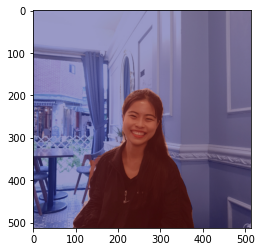

In [348]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

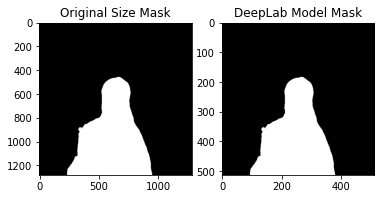

In [349]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

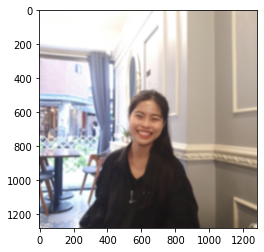

In [350]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

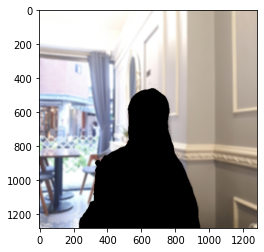

In [351]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

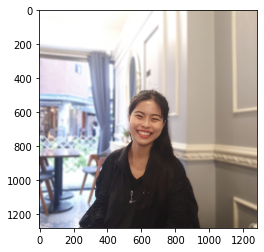

In [352]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이 사진으로 해보기

In [353]:
#고양이 사진 불러오기
img_path_cat=os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpg'
img_orig_cat=cv2.imread(img_path_cat)
print(img_orig_cat.shape)

(960, 720, 3)


In [354]:
# 고양이 사진 이미지 크기 수정
img_resized_cat, seg_map_cat = MODEL.run(img_orig_cat)
print (img_orig_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(960, 720, 3) (513, 384, 3) 8


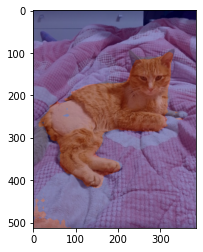

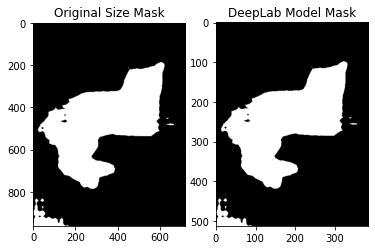

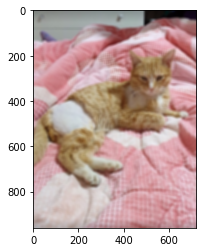

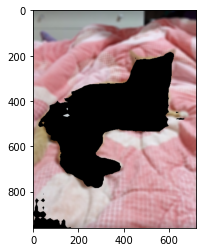

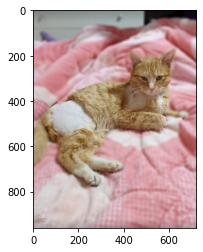

In [355]:
img_show = img_resized_cat.copy()
seg_map = np.where(seg_map == LABEL_NAMES.index('cat'), LABEL_NAMES.index('cat'), 0) #예측 중 고양이 피쳐만 추출
img_mask = seg_map_cat * (255/seg_map_cat.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

img_orig_blur = cv2.blur(img_orig_cat, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #이미지 반전
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 크로마키 해보기
인물 사진의 배경을 하늘로 바꿔보았다.

(1280, 1280, 3)
(1280, 1280, 3) (513, 513, 3) 15


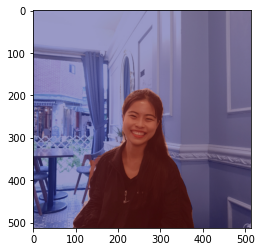

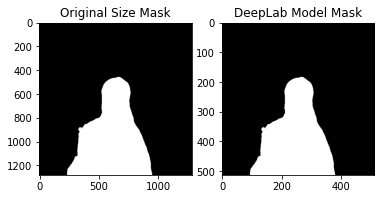

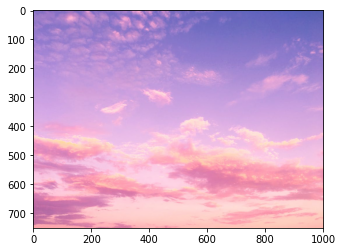

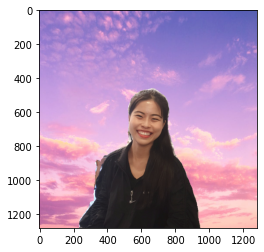

In [356]:
#인물 사진 불러오기
img_path=os.getenv('HOME')+'/aiffel/human_segmentation/images/yejin.jpg'
img_orig=cv2.imread(img_path)
print(img_orig.shape)

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#배경 이미지 불러오기
bg_img_path=os.getenv('HOME')+'/aiffel/human_segmentation/images/sky.jpeg'
bg_orig = cv2.imread(bg_img_path)
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()
    
#합성 할 이미지의 원본 사이즈와 배경 이미지가 동일해야 합성할 수 있음.
target_size = (img_orig.shape[1], img_orig.shape[0])
bg_resized = cv2.resize(bg_orig, target_size)
    
#배경 이미지와 잘라 낸 이미지 합성
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 찾기
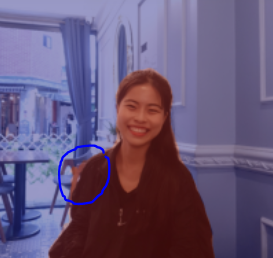
- 뒤에 있는 의자까지 사람으로 인식한 것을 알 수 있다.

# 해결방안 생각해보기

의자가 사람보다 더 뒤에 있으므로 사람과 의자의 위치가 다르다는 것을 카메라가 인식할 수 있다면 문제가 해결 될 것 같다.

## 3D Depth Camera
- 촬영자로부터 특정 물체나 지점까지의 거리를 측정하여 3차원의 Depth Map을 추출하는 기술을 말한다.
- 3가지 방식으로 분류 할 수 있는데, 1) 스테레오 방식, 2) 구조광 방식, 3) ToF 방식으로 나눌 수 있다.

1. 스테레오 방식
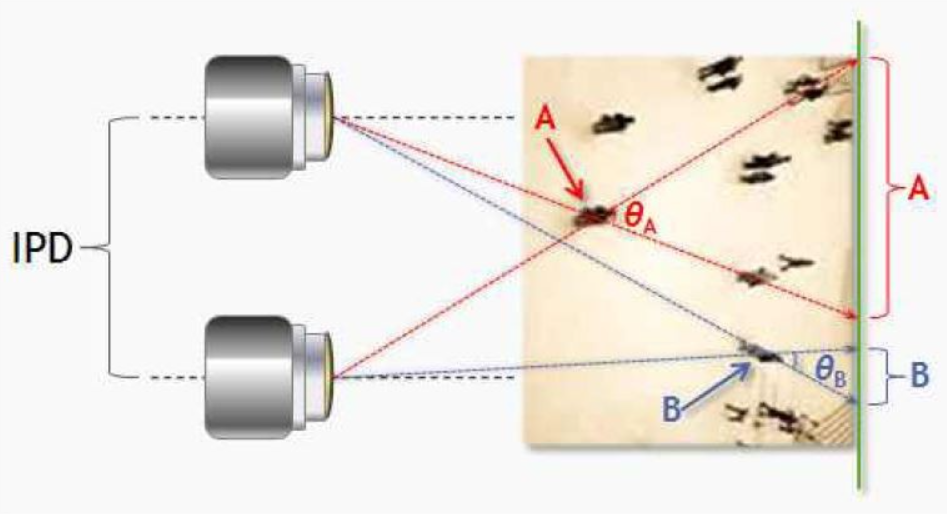
그림을 보면 두 개의 카메라가 하나의 물체를 비추고 있는 것을 볼 수 있다. 특정 물체와의 거리를 계산하기 위해 한 쌍의 동일한 카메라를 이용하는데, 카메라들 사이의 시점 불일치를 이용한다. IPD는 카메라 쌍에 의해 생기는 피사체의 각도 간격을 결정하고, 시차 검출에 중요한 역할을 한다. 요즘 나오는 핸드폰에 카메라가 2개 이상 달려있는 이유가 되기도 하며, 두 눈이 사물의 위치를 인식하는 방식과 닮았다.  
2. 구조광 방식  
구조광 방식은 물체에 특정 광 패턴을 주사해서 패턴의 변화량을 계산하여 인식하는 방식이다. 이 방식은 카메라와 투영기 간의 분리로 특정 지점을 찾고, 삼각 측량 알고리즘을 사용하여 깊이를 계산한다.
3. ToF 방식
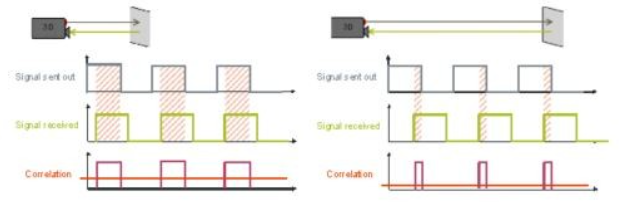
ToF 방식은 물체로부터 반사되는 빛의 이동시간을 계산하여 인식하는 방식이다. 다른 방식에 비해 인식 거리가 길고, 전력 소모가 적은 장점이 있다. 
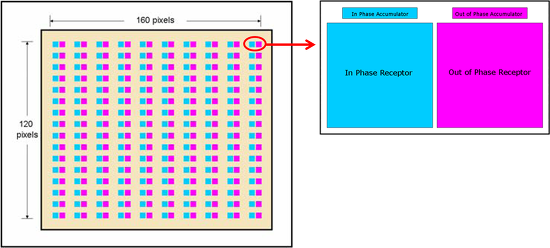
각각의 셀이 2개씩의 receptor 쌍으로 구성되어 있는데, 카메라부터 빛을 쏘아 반사되어 돌아오는 빛을 감지하는 부분이 receptor이다. 각 receptor들은 in phase receptor(하늘색)와 out phase receptor(붉은색)쌍으로 구성되어 있다. inphase receptor은 in phase에만 활성화되어 빛을 감지하고, out phase receptor은 out phase에만 활성화되어 빛을 감지한다. 거리가 0인 경우에는 in phase receptor에만 빛이 수신되고, 점점 거리가 멀어지면 in phase receptor에 수신되는 빛의 양은 줄어들고 out phase receptor에 수신되는 빛의 양은 증가한다. 이 차이로 거리를 계산하는 방식이다.

# 회고
- 처음에 고양이 사진이 인식이 안되서 계속 여러 장의 고양이 사진으로 교체했었다. 하지만 seg_map = np.where(seg_map == 15, 15, 0)가 사람만을 추출한다는 것을 알게 되어 수정하니깐 작동을 잘 했다.
- 원리를 생각하지 않고 편하게 쓰던 카메라 어플들이 이렇게 복잡한 방식으로 한다는 것을 알게 되어서 신기했다.
- 아직은 포토샵으로 직접 누끼를 따는 것이 더 깔끔하다는 생각이 들어서 어떻게 해야지 더 깔끔하게 인식을 할 수 있는지 궁금하다.